In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("iemocap_audio_balanced.csv")

# Display the first 5 rows
df.head()

,utterance_id,audio_path,emotion
0,Ses01M_script03_1_F001,IEMOCAP_full_release\Session1\sentences\wav\Se...,fear
1,Ses03F_impro02_M005,IEMOCAP_full_release\Session3\sentences\wav\Se...,surprise
2,Ses01F_script03_1_M000,IEMOCAP_full_release\Session1\sentences\wav\Se...,fear
3,Ses04M_script02_1_M020,IEMOCAP_full_release\Session4\sentences\wav\Se...,excited
4,Ses03M_script01_3_M032,IEMOCAP_full_release\Session3\sentences\wav\Se...,sadness


In [2]:
import pandas as pd

# Load the balanced audio CSV
df = pd.read_csv("iemocap_audio_balanced.csv")

# Display the emotion distribution
emotion_counts = df['emotion'].value_counts()

print("Emotion Distribution:\n")
print(emotion_counts)

Emotion Distribution:

emotion
fear           1849
surprise       1849
excited        1849
sadness        1849
frustration    1849
happiness      1849
neutral        1849
anger          1849
Name: count, dtype: int64


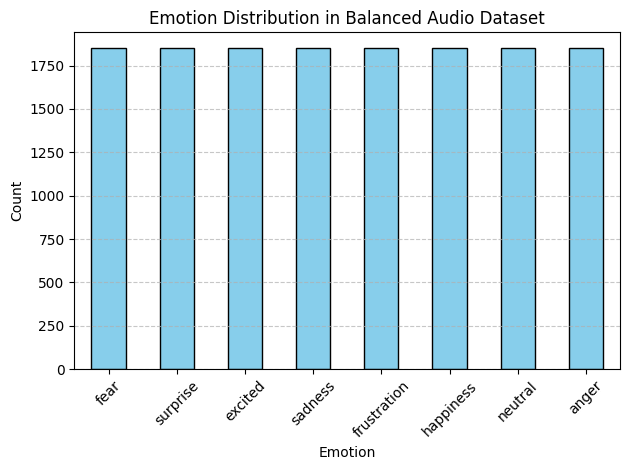

In [3]:
import matplotlib.pyplot as plt

# Bar chart of emotion distribution
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Emotion Distribution in Balanced Audio Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 2: Audio Feature Extraction with librosa

In [4]:
# STEP 1: Audio Feature Extraction with librosa

import librosa
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os

# Parameters
SAMPLE_RATE = 16000
N_MFCC = 40
N_MELS = 128
AUDIO_LEN = 4  # seconds
TARGET_LENGTH = SAMPLE_RATE * AUDIO_LEN

# Load balanced audio CSV
df = pd.read_csv("iemocap_audio_balanced.csv")

features = []
labels = []
utt_ids = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting audio features"):
    audio_path = row['audio_path']
    label = row['emotion']
    utt_id = row['utterance_id']  # Needed for fusion with text
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
        # Trim/pad to target length
        if len(y) < TARGET_LENGTH:
            y = np.pad(y, (0, TARGET_LENGTH - len(y)))
        else:
            y = y[:TARGET_LENGTH]
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
        mfcc_mean = mfcc.mean(axis=1)
        # Extract Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_mean = mel.mean(axis=1)
        # Concatenate features
        feat = np.concatenate([mfcc_mean, mel_mean])
        features.append(feat)
        labels.append(label)
        utt_ids.append(utt_id)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Convert to arrays and save
features = np.stack(features)
labels = np.array(labels)
utt_ids = np.array(utt_ids)

print(f"Extracted feature shape: {features.shape}")

np.save("audio_features.npy", features)
np.save("audio_labels.npy", labels)
np.save("audio_utt_ids.npy", utt_ids)

print("Saved features to 'audio_features.npy', labels to 'audio_labels.npy', and utterance IDs to 'audio_utt_ids.npy'")

Extracting audio features:   0%|          | 0/14792 [00:00<?, ?it/s]

Extracted feature shape: (14792, 168)
Saved features to 'audio_features.npy', labels to 'audio_labels.npy', and utterance IDs to 'audio_utt_ids.npy'


# Step 3: Train Baseline SVM Classifier

Test Accuracy: 0.5590
Test Macro F1: 0.5428

              precision    recall  f1-score   support

       anger       0.60      0.52      0.56       370
     excited       0.58      0.48      0.52       369
        fear       0.72      0.97      0.82       370
 frustration       0.41      0.31      0.35       370
   happiness       0.54      0.38      0.44       370
     neutral       0.41      0.35      0.38       370
     sadness       0.53      0.66      0.59       370
    surprise       0.58      0.80      0.67       370

    accuracy                           0.56      2959
   macro avg       0.55      0.56      0.54      2959
weighted avg       0.55      0.56      0.54      2959



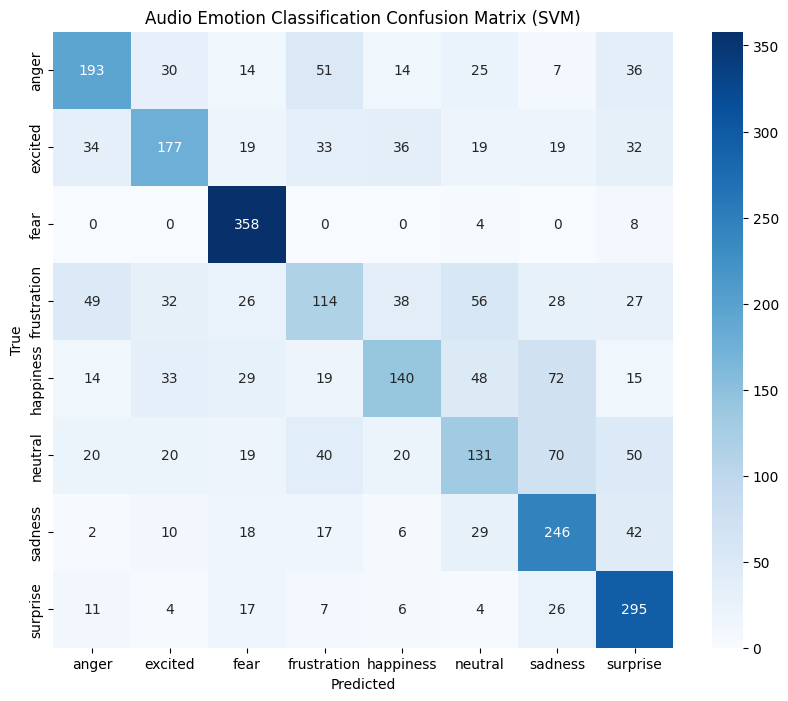

Model and scaler saved.


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load features and labels
X = np.load("audio_features.npy")
y = np.load("audio_labels.npy")

# Encode labels (same order as text model for consistency)
label_encoder = LabelEncoder()
label_encoder.fit(['anger', 'excited', 'fear', 'frustration', 
                   'happiness', 'neutral', 'sadness', 'surprise'])
y_encoded = label_encoder.transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1: {f1_macro:.4f}\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Audio Emotion Classification Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save model and scaler
import joblib
joblib.dump(clf, "audio_svm_model.joblib")
joblib.dump(scaler, "audio_scaler.joblib")
print("Model and scaler saved.")

# Build a CNN-LSTM model in Keras for audio embeddings

In [6]:
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import pickle

# --------------------------
# Step 1: Build CNN-LSTM Model with 768D Embeddings
# --------------------------
def build_cnn_lstm(input_shape=(168,1), lstm_dim=256, final_embedding_dim=768):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.LSTM(lstm_dim, name='lstm')(x)

    # Add Dense layer to map LSTM output to 768 dimensions
    embeddings = layers.Dense(final_embedding_dim, activation='relu', name='dense_768')(x)

    outputs = layers.Dense(8, activation='softmax')(embeddings)

    # Full classification model
    model = models.Model(inputs, outputs)

    # Embedding model (before final classification)
    embedding_model = models.Model(inputs, embeddings)

    return model, embedding_model

# Instantiate models
model, embedding_model = build_cnn_lstm()
model.summary()

# --------------------------
# Step 2: Load and Preprocess Data
# --------------------------
X = np.load("audio_features.npy")  # shape: (num_samples, 168)
y = np.load("audio_labels.npy")    # shape: (num_samples,)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Reshape for CNN-LSTM input
X = X[..., np.newaxis]  # shape: (num_samples, 168, 1)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# --------------------------
# Step 3: Compile and Train Model
# --------------------------
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64)

# --------------------------
# Step 4: Extract 768D Embeddings for Fusion
# --------------------------
embeddings = embedding_model.predict(X, batch_size=64, verbose=1)
print("Updated Embeddings shape (should be 768):", embeddings.shape)  # (num_samples, 768)

# Save embeddings and labels
np.save("audio_embeddings_768d.npy", embeddings)
np.save("audio_labels_encoded.npy", y_encoded)

# Save label encoder classes
with open("label_encoder_classes.pkl", "wb") as f:
    pickle.dump(le.classes_, f)

# Save trained model
model.save("audio_cnn_lstm_model_768d.keras")  
print("Model saved as 'audio_cnn_lstm_model_768d.keras'")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 168, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 168, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 84, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 84, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 42, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_768 (Dense)                    │ (None, 768)                 │         197,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,152 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 639,240 (2.44 MB)

 Trainable params: 639,240 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.2046 - loss: 1.9673 - val_accuracy: 0.2518 - val_loss: 1.9083
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.2705 - loss: 1.8683 - val_accuracy: 0.3116 - val_loss: 1.8089
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.3260 - loss: 1.7410 - val_accuracy: 0.3521 - val_loss: 1.6731
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.3713 - loss: 1.6188 - val_accuracy: 0.4353 - val_loss: 1.4665
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4420 - loss: 1.4366 - val_accuracy: 0.4769 - val_loss: 1.3623
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4784 - loss: 1.3470 - val_accuracy: 0.5039 - val_loss: 1.2524
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5086 - loss: 1.2324 - val_accuracy: 0.5042 - val_loss: 1.2281
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5316 - loss: 1.1786 - 

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('audio_cnn_lstm_model_768d.keras')

In [10]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import sounddevice as sd

# Parameters matching training
SAMPLE_RATE = 16000
N_MFCC = 40
N_MELS = 128
AUDIO_LEN = 4  # seconds
TARGET_LENGTH = SAMPLE_RATE * AUDIO_LEN

# Load label encoder classes (same order as training)
label_list = ['anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise']

# Load your new trained model
model = load_model("audio_cnn_lstm_model.keras")

def extract_features(audio_path_or_array):
    if isinstance(audio_path_or_array, str):
        y, sr = librosa.load(audio_path_or_array, sr=SAMPLE_RATE, mono=True)
    else:
        y = audio_path_or_array
        sr = SAMPLE_RATE
    if len(y) < TARGET_LENGTH:
        y = np.pad(y, (0, TARGET_LENGTH - len(y)))
    else:
        y = y[:TARGET_LENGTH]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mfcc_mean = mfcc.mean(axis=1)
    mel_mean = mel.mean(axis=1)
    feat = np.concatenate([mfcc_mean, mel_mean])
    return feat

def predict_emotion_single(audio_input):
    feat = extract_features(audio_input)
    feat = feat[np.newaxis, :, np.newaxis]  # (1, 168, 1)
    preds = model.predict(feat)
    pred_idx = np.argmax(preds)
    confidence = preds[0][pred_idx]
    label = label_list[pred_idx]
    print(f"Predicted Emotion: {label} (Confidence: {confidence:.4f})")
    return label, confidence

def predict_emotion_batch(audio_paths):
    results = []
    for path in audio_paths:
        try:
            label, conf = predict_emotion_single(path)
            results.append({'file': path, 'emotion': label, 'confidence': conf})
        except Exception as e:
            results.append({'file': path, 'error': str(e)})
    return results

def record_audio(duration=AUDIO_LEN):
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    audio_np = recording.flatten()
    print("Recording complete.")
    return audio_np

# Example usage:
if __name__ == "__main__":
    # Single file prediction
    audio_file = "IEMOCAP_full_release\Session5\sentences\wav\Ses05M_script01_3\Ses05M_script01_3_M018.wav"
    print("Single audio file prediction:")
    predict_emotion_single(audio_file)

    # Batch prediction example
    # audio_files = ["file1.wav", "file2.wav", "file3.wav"]
    # batch_results = predict_emotion_batch(audio_files)
    # print(batch_results)

    # Real-time recording prediction
    # recorded_audio = record_audio()
    # predict_emotion_single(recorded_audio)

<>:67: SyntaxWarning: invalid escape sequence '\S'
<>:67: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_16008\146156196.py:67: SyntaxWarning: invalid escape sequence '\S'
  audio_file = "IEMOCAP_full_release\Session5\sentences\wav\Ses05M_script01_3\Ses05M_script01_3_M018.wav"


Single audio file prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted Emotion: surprise (Confidence: 0.9995)


## Step: 5 Here is a complete audio inference pipeline using your trained TensorFlow CNN model with consistent audio preprocessing (MFCC + Mel features) for single or batch prediction, plus optional real-time audio recording.

In [12]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from tqdm.auto import tqdm
import sounddevice as sd

# Parameters matching training
SAMPLE_RATE = 16000
N_MFCC = 40
N_MELS = 128
AUDIO_LEN = 4  # seconds
TARGET_LENGTH = SAMPLE_RATE * AUDIO_LEN

# Load label encoder classes (same order as training)
label_list = ['anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise']

# Load trained model (adjust path and extension as needed)
model = load_model("audio_cnn_tf_model.keras")

def extract_features(audio_path_or_array):
    # Accept either file path or numpy array (recorded audio)
    if isinstance(audio_path_or_array, str):
        y, sr = librosa.load(audio_path_or_array, sr=SAMPLE_RATE, mono=True)
    else:
        y = audio_path_or_array
        sr = SAMPLE_RATE
    # Pad or trim
    if len(y) < TARGET_LENGTH:
        y = np.pad(y, (0, TARGET_LENGTH - len(y)))
    else:
        y = y[:TARGET_LENGTH]
    # Extract MFCC and Mel
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mfcc_mean = mfcc.mean(axis=1)
    mel_mean = mel.mean(axis=1)
    feat = np.concatenate([mfcc_mean, mel_mean])
    return feat

def predict_emotion_single(audio_input):
    feat = extract_features(audio_input)
    feat = feat[np.newaxis, :, np.newaxis]  # reshape for model: (1, features_length, 1)
    preds = model.predict(feat)
    pred_idx = np.argmax(preds)
    confidence = preds[0][pred_idx]
    label = label_list[pred_idx]
    print(f"Predicted Emotion: {label} (Confidence: {confidence:.4f})")
    return label, confidence

def predict_emotion_batch(audio_paths):
    results = []
    for path in tqdm(audio_paths, desc="Batch prediction"):
        try:
            label, conf = predict_emotion_single(path)
            results.append({'file': path, 'emotion': label, 'confidence': conf})
        except Exception as e:
            results.append({'file': path, 'error': str(e)})
    return results

def record_audio(duration=AUDIO_LEN):
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    audio_np = recording.flatten()
    print("Recording complete.")
    return audio_np

# Example usage:
if __name__ == "__main__":
    # Single file prediction
    audio_file = "IEMOCAP_full_release\Session1\sentences\wav\Ses01F_impro03\Ses01F_impro03_F008.wav"
    print("Single audio file prediction:")
    predict_emotion_single(audio_file)

    # Batch prediction example
    # audio_files = ["file1.wav", "file2.wav", "file3.wav"]
    # batch_results = predict_emotion_batch(audio_files)
    # print(batch_results)

    # Real-time recording prediction
    # recorded_audio = record_audio()
    # predict_emotion_single(recorded_audio)


<>:72: SyntaxWarning: invalid escape sequence '\S'
<>:72: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_12320\3736724997.py:72: SyntaxWarning: invalid escape sequence '\S'
  audio_file = "IEMOCAP_full_release\Session1\sentences\wav\Ses01F_impro03\Ses01F_impro03_F008.wav"


Single audio file prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted Emotion: happiness (Confidence: 0.9555)


In [14]:
# Example usage:
if __name__ == "__main__":
    # Single file prediction
    #audio_file = "path/to/audio.wav"
    #print("Single audio file prediction:")
    #predict_emotion_single(audio_file)

    # Batch prediction example
      audio_files = ["IEMOCAP_full_release\Session5\sentences\wav\Ses05M_script01_3\Ses05M_script01_3_M018.wav", "IEMOCAP_full_release\Session5\sentences\wav\Ses05F_script02_2\Ses05F_script02_2_F030.wav"]
      batch_results = predict_emotion_batch(audio_files)
      print(batch_results)

    # Real-time recording prediction
    # recorded_audio = record_audio()
    # predict_emotion_single(recorded_audio)

<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_12320\3195211651.py:9: SyntaxWarning: invalid escape sequence '\S'
  audio_files = ["IEMOCAP_full_release\Session5\sentences\wav\Ses05M_script01_3\Ses05M_script01_3_M018.wav", "IEMOCAP_full_release\Session5\sentences\wav\Ses05F_script02_2\Ses05F_script02_2_F030.wav"]
C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_12320\3195211651.py:9: SyntaxWarning: invalid escape sequence '\S'
  audio_files = ["IEMOCAP_full_release\Session5\sentences\wav\Ses05M_script01_3\Ses05M_script01_3_M018.wav", "IEMOCAP_full_release\Session5\sentences\wav\Ses05F_script02_2\Ses05F_script02_2_F030.wav"]


Batch prediction:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Emotion: surprise (Confidence: 0.9996)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: sadness (Confidence: 0.9748)
[{'file': 'IEMOCAP_full_release\\Session5\\sentences\\wav\\Ses05M_script01_3\\Ses05M_script01_3_M018.wav', 'emotion': 'surprise', 'confidence': 0.99956304}, {'file': 'IEMOCAP_full_release\\Session5\\sentences\\wav\\Ses05F_script02_2\\Ses05F_script02_2_F030.wav', 'emotion': 'sadness', 'confidence': 0.97475624}]


In [16]:
#ad374ee4b0464e9aa1366f9a1eaa0eee

In [1]:
import requests
import time
import sounddevice as sd
import numpy as np
import wave
import torch
import torch.nn.functional as F
from transformers import BertTokenizerFast, BertForSequenceClassification

# AssemblyAI API key
API_KEY = "ad374ee4b0464e9aa1366f9a1eaa0eee"

HEADERS = {
    "authorization": API_KEY,
    "content-type": "application/json"
}

UPLOAD_ENDPOINT = "https://api.assemblyai.com/v2/upload"
TRANSCRIPT_ENDPOINT = "https://api.assemblyai.com/v2/transcript"

# Load BERT model and tokenizer for emotion prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_path = "bert_finetuned_iemocap"  # adjust path as needed
tokenizer = BertTokenizerFast.from_pretrained(bert_model_path)
model = BertForSequenceClassification.from_pretrained(bert_model_path)
model.to(device)
model.eval()

label_list = ['anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise']

def record_audio(duration=4, filename="recorded.wav", sample_rate=16000):
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    audio_np = recording.flatten()

    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)  # 16-bit audio
        wf.setframerate(sample_rate)
        wf.writeframes((audio_np * 32767).astype(np.int16).tobytes())
    print(f"Recording saved to {filename}")
    return filename

def upload_audio(filename):
    def read_file(filename, chunk_size=5242880):
        with open(filename, 'rb') as _file:
            while True:
                data = _file.read(chunk_size)
                if not data:
                    break
                yield data

    print("Uploading audio...")
    response = requests.post(UPLOAD_ENDPOINT, headers={"authorization": API_KEY}, data=read_file(filename))
    response.raise_for_status()
    upload_url = response.json()['upload_url']
    print(f"Upload complete: {upload_url}")
    return upload_url

def request_transcription(audio_url):
    print("Requesting transcription...")
    transcript_request = {
        "audio_url": audio_url,
        "language_code": "en_us"
    }
    response = requests.post(TRANSCRIPT_ENDPOINT, json=transcript_request, headers=HEADERS)
    response.raise_for_status()
    transcript_id = response.json()['id']
    print(f"Transcript requested with ID: {transcript_id}")
    return transcript_id

def poll_transcription(transcript_id, interval=5):
    polling_endpoint = f"{TRANSCRIPT_ENDPOINT}/{transcript_id}"
    while True:
        response = requests.get(polling_endpoint, headers=HEADERS)
        response.raise_for_status()
        status = response.json()['status']
        if status == 'completed':
            print("Transcription completed.")
            return response.json()['text']
        elif status == 'error':
            raise RuntimeError(f"Transcription failed: {response.json()['error']}")
        else:
            print(f"Transcription status: {status}. Waiting {interval} seconds...")
            time.sleep(interval)

def predict_emotion_from_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = probs.argmax()
        pred_label = label_list[pred_idx]
        confidence = probs[pred_idx]
    print(f"\nTranscription: {text}")
    print(f"Predicted Emotion: {pred_label} (Confidence: {confidence:.4f})")
    return pred_label, confidence

if __name__ == "__main__":
    audio_file = record_audio()
    audio_url = upload_audio(audio_file)
    transcript_id = request_transcription(audio_url)
    transcription_text = poll_transcription(transcript_id)
    predict_emotion_from_text(transcription_text)

Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/d78b1048-0e12-4333-a75e-ee056aa32b8a
Requesting transcription...
Transcript requested with ID: d85645a0-922d-4672-97e1-a78be4a80748
Transcription completed.

Transcription: Hello. I have a very nice.
Predicted Emotion: happiness (Confidence: 0.6689)


# Creating a Sequence of Emotions from Multiple Recordings

In [5]:
emotion_to_code = {
    'anger': 'a', 'excited': 'e', 'fear': 'f', 'frustration': 'r',
    'happiness': 'h', 'neutral': 'n', 'sadness': 's', 'surprise': 'u'
}

sequence = ""
for i in range(5):
    print(f"\nRecording segment {i+1} of 5")
    audio_file = record_audio()
    audio_url = upload_audio(audio_file)
    transcript_id = request_transcription(audio_url)
    transcription_text = poll_transcription(transcript_id)
    emotion, _ = predict_emotion_from_text(transcription_text)
    sequence += emotion_to_code[emotion]

print(f"\nEmotion sequence from 5 recordings: {sequence}")


Recording segment 1 of 5
Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/93520ceb-65cd-4294-bf76-1e13e776eebe
Requesting transcription...
Transcript requested with ID: ff4c04e8-64b0-4ebc-9222-c352957be396
Transcription completed.

Transcription: Hello. I am so happy today.
Predicted Emotion: excited (Confidence: 0.5910)

Recording segment 2 of 5
Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/52b08a3b-2a5a-4aa9-825a-310fa186c2a9
Requesting transcription...
Transcript requested with ID: 4bd4f055-c731-4cc8-a951-c7bab3ee08c8
Transcription completed.

Transcription: I am very much angry and frustrated.
Predicted Emotion: anger (Confidence: 0.9352)

Recording segment 3 of 5
Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/474af126-27b

In [14]:
CONFIDENCE_THRESHOLD = 0.6
sequence = ""
for i in range(5):
    print(f"\nRecording segment {i+1} of 5")
    audio_file = record_audio()
    audio_url = upload_audio(audio_file)
    transcript_id = request_transcription(audio_url)
    transcription_text = poll_transcription(transcript_id)
    emotion, confidence = predict_emotion_from_text(transcription_text)
    
    if confidence < CONFIDENCE_THRESHOLD:
        print(f"Low confidence ({confidence:.2f}) for segment {i+1}, marking as 'unknown'")
        sequence += "x"  # x for uncertain emotion
    else:
        sequence += emotion_to_code[emotion]

print(f"\nEmotion sequence from 5 recordings: {sequence}")


Recording segment 1 of 5
Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/25be73b7-862b-459f-843f-88d47d100484
Requesting transcription...
Transcript requested with ID: c054f48e-9c26-4e05-842f-bdb36f3cf2be
Transcription status: processing. Waiting 5 seconds...
Transcription completed.

Transcription: I love to play cricket.
Predicted Emotion: excited (Confidence: 0.8423)

Recording segment 2 of 5
Recording audio for 4 seconds...
Recording saved to recorded.wav
Uploading audio...
Upload complete: https://cdn.assemblyai.com/upload/ec387d32-9c50-4165-bc6a-e000ba90d182
Requesting transcription...
Transcript requested with ID: fbd057a5-2930-4d1f-8e21-a5db12d18ef3
Transcription completed.

Transcription: This is very good game.
Predicted Emotion: excited (Confidence: 0.4176)
Low confidence (0.42) for segment 2, marking as 'unknown'

Recording segment 3 of 5
Recording audio for 4 seconds...
Recording saved 

# Python script to visualize waveform, spectrogram, and MFCC heatmap of an audio file

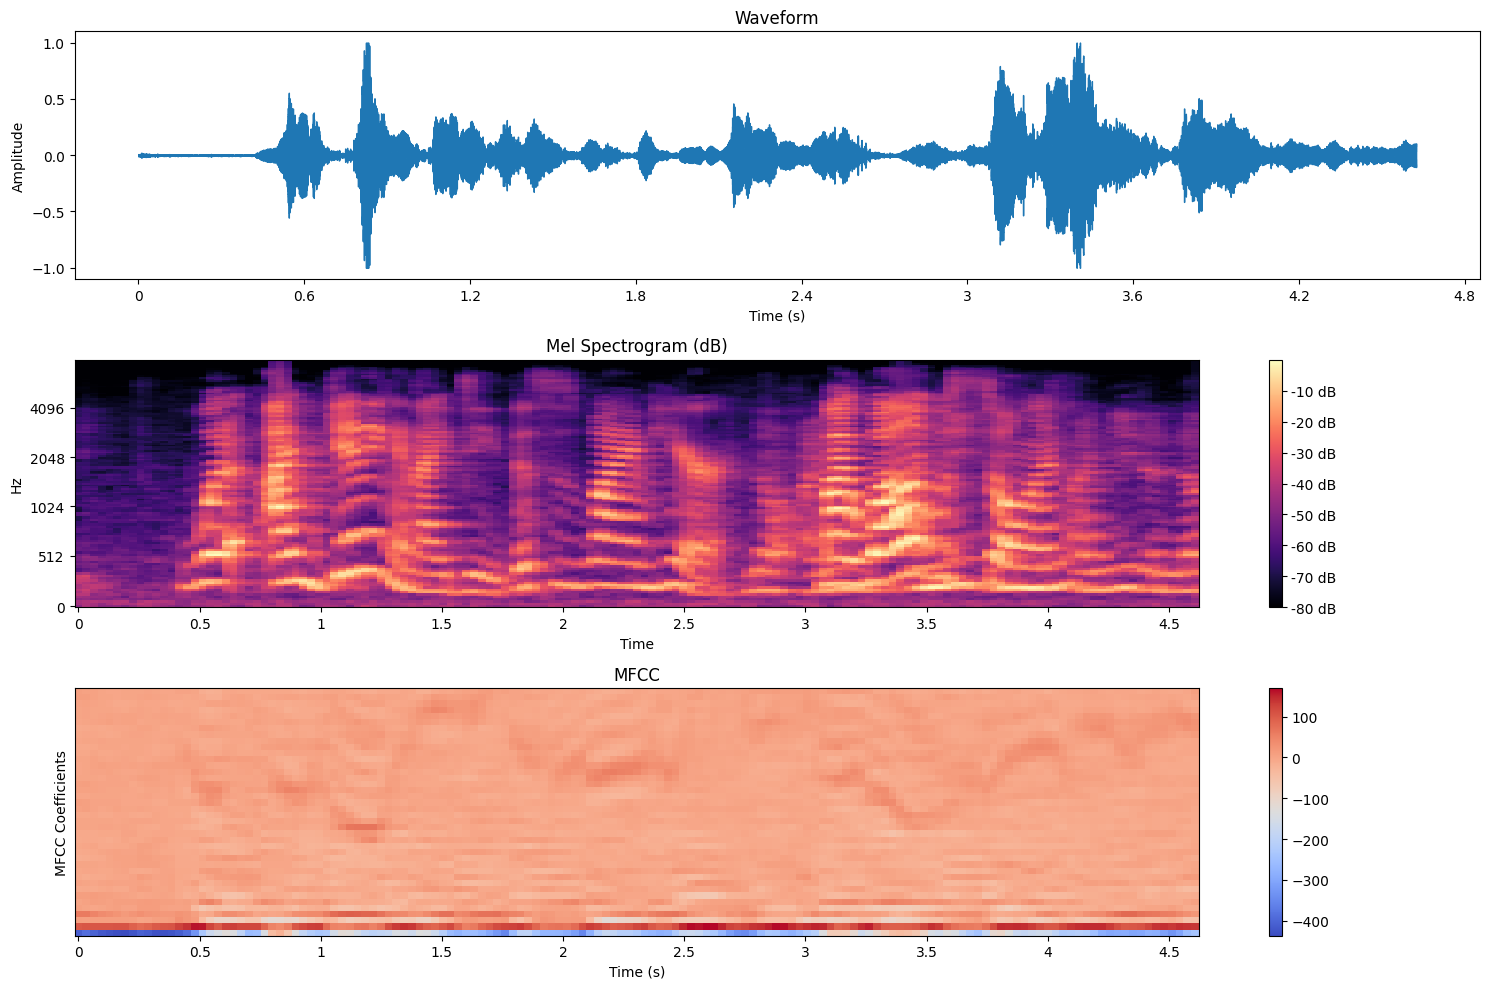

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_audio_features(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)
    
    plt.figure(figsize=(15, 10))

    # 1. Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # 2. Mel Spectrogram (log-scaled)
    plt.subplot(3, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(img, format='%+2.0f dB')
    plt.title("Mel Spectrogram (dB)")

    # 3. MFCC heatmap
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    img2 = librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar(img2)
    plt.title("MFCC")
    plt.ylabel("MFCC Coefficients")
    plt.xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

# Example usage with corrected path string:
audio_file = r"IEMOCAP_full_release\Session1\sentences\wav\Ses01F_impro01\Ses01F_impro01_F006.wav"
# or use forward slashes:
# audio_file = "IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F006.wav"

if os.path.exists(audio_file):
    plot_audio_features(audio_file)
else:
    print(f"File not found: {audio_file}")